In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib
import pickle
import h5py
import cv2
import scipy

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/fer2013.csv')

In [0]:
def get_images(usage):
  df = dataset[dataset['Usage'] == usage]
  y = tf.keras.utils.to_categorical(df['emotion'])
  X = np.array([values.split() for values in df['pixels']])
  X = X.astype(np.float).reshape(len(df), 48, 48, 1)
  return (X, y)

In [0]:
X_train, y_train = get_images('Training')
X_test, y_test =  get_images('PublicTest')
X_validate, y_validate = get_images('PrivateTest')

In [6]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

print('X_validate:', X_validate.shape)
print('y_validate:', y_validate.shape)

X_train: (28709, 48, 48, 1)
y_train: (28709, 7)
X_test: (3589, 48, 48, 1)
y_test: (3589, 7)
X_validate: (3589, 48, 48, 1)
y_validate: (3589, 7)


In [0]:
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')
val_data = X_validate.astype('float32')

train_data /= 255
test_data /= 255
val_data /= 255

In [0]:
def get_label(arg):
  labels = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}
  return (labels.get(arg,"Invalid Emotion"))

In [0]:
shape_x = 48
shape_y = 48

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, (3,3),padding="same", activation='swish', input_shape=(48, 48, 1),  data_format='channels_last',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='swish', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.5),
  
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='swish', padding='same'),
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='swish', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='swish', padding='same'),
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='swish', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='swish', padding='same'),
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='swish', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(512, activation='swish'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(256, activation='swish'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation='swish'),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(7, activation = 'softmax')
  ])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

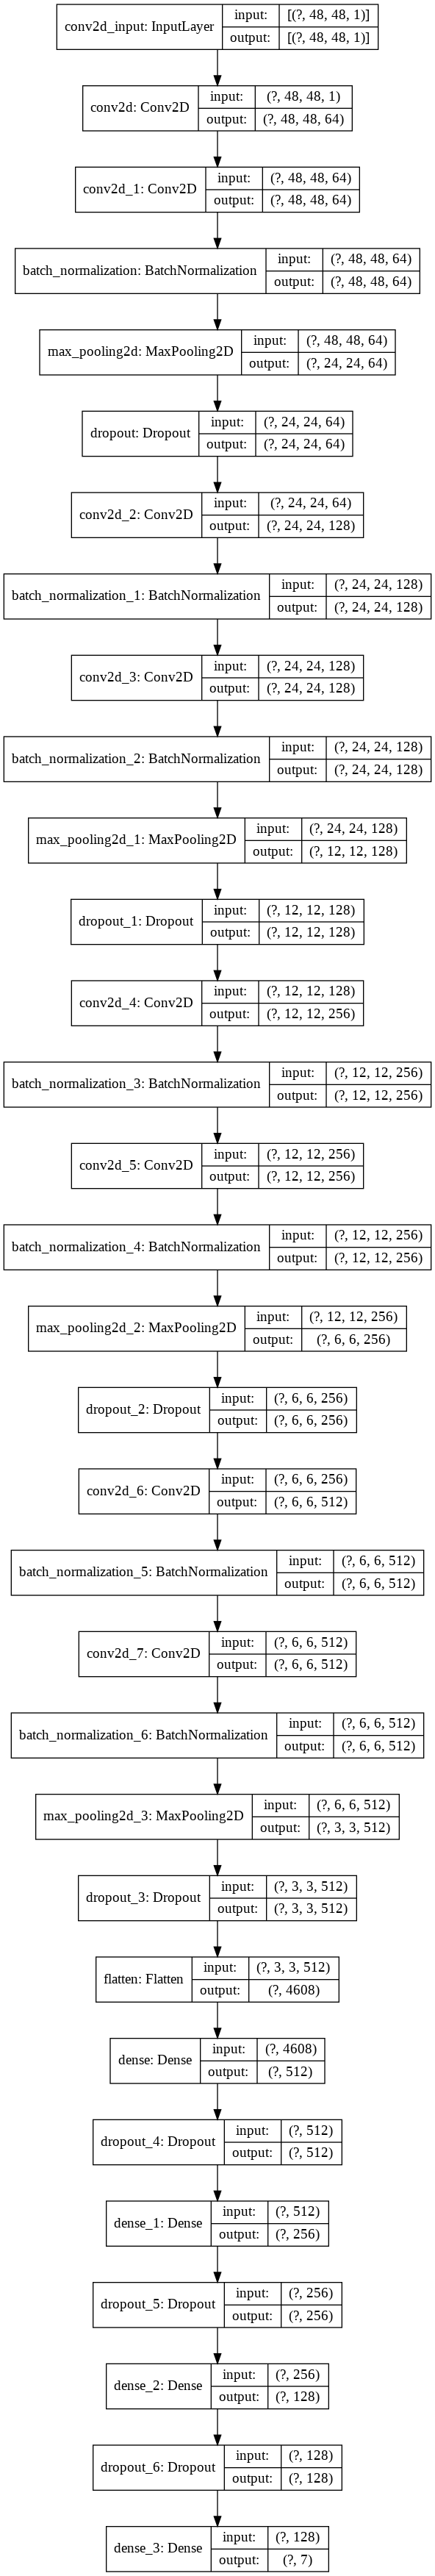

In [12]:
tf.keras.utils.plot_model(model, to_file='model_fer.png', show_shapes=True, show_layer_names=True)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer_d = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, verbose=1)

tensorboard_d = tf.keras.callbacks.TensorBoard(log_dir='./logs')

early_stopper_d = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')

checkpointer_d = tf.keras.callbacks.ModelCheckpoint('model_fer.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

In [16]:
history = model.fit(
    datagen.flow(train_data, y_train, batch_size=256),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(256))),
    epochs = 200,
    shuffle=True, 
    validation_data=(val_data, y_validate),
    callbacks=[lr_reducer_d, tensorboard_d, early_stopper_d, checkpointer_d]
)

Epoch 1/200
113/113 [==============================] - ETA: 0s - loss: 2.0954 - accuracy: 0.2046
Epoch 00001: val_loss improved from inf to 1.86664, saving model to model_fer.h5
113/113 [==============================] - 24s 210ms/step - loss: 2.0954 - accuracy: 0.2046 - val_loss: 1.8666 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - ETA: 0s - loss: 1.8471 - accuracy: 0.2350
Epoch 00002: val_loss improved from 1.86664 to 1.83624, saving model to model_fer.h5
113/113 [==============================] - 22s 198ms/step - loss: 1.8471 - accuracy: 0.2350 - val_loss: 1.8362 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - ETA: 0s - loss: 1.8201 - accuracy: 0.2494
Epoch 00003: val_loss improved from 1.83624 to 1.82580, saving model to model_fer.h5
113/113 [==============================] - 22s 199ms/step - loss: 1.8201 - accuracy: 0.2494 - val_loss: 1.8258 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 4/200
113/1

Text(0.5, 1.0, 'Accuracy Curves')

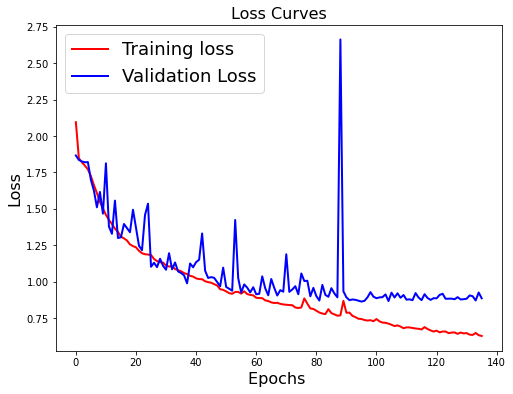

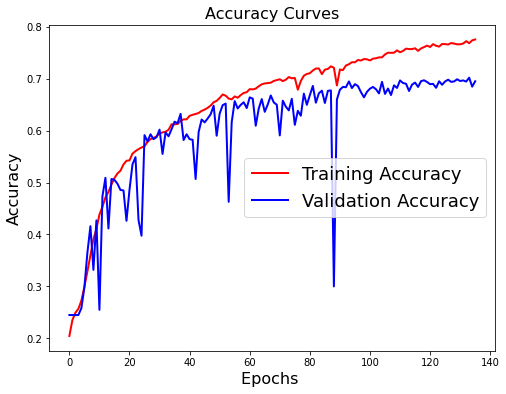

In [17]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [0]:
def detect_face(image):
  cascPath = '/content/drive/My Drive/BE Project/sarvesh/haarcascades/haarcascade_frontalface_default.xml'
  faceCascade = cv2.CascadeClassifier(cascPath)
  #BGR to gray conversion
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Cascade multiscale classifier
  detected_faces = faceCascade.detectMultiScale(image, minNeighbors=3,
                                                minSize=(10,10)
  )
  sub = gray

  for x, y, w, h in detected_faces:
    #if w>100:
      sub = gray[y:y+h,x:x+w]
  return sub,detected_faces

In [0]:
from google.colab.patches import cv2_imshow

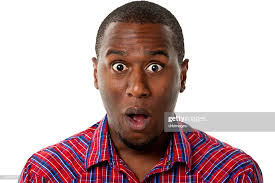

(183, 275, 3)
(99, 99)


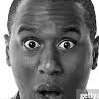

(48, 48)
(1, 48, 48, 1)


In [68]:
image = cv2.imread('/content/drive/My Drive/Datasets/sample_images/person_su3.jpg',1)
cv2_imshow(image)
print(image.shape)
sub_img2,detected_face = detect_face(image)
print(sub_img2.shape)
cv2_imshow(sub_img2)
sub_img = cv2.resize(sub_img2, (48,48), interpolation = cv2.INTER_AREA)
sub_img = sub_img/255
#cv2_imshow(sub_img)
print(sub_img.shape)
sub_img = np.reshape(sub_img, (1,48,48,1))
print(sub_img.shape)

In [69]:
pred_array = model.predict(sub_img)
print(pred_array)
pred_array_new= np.squeeze(pred_array)
prediction = np.argmax(pred_array_new)
print(pred_array_new)
print(prediction)
print(get_label(prediction))

[[6.2136864e-03 1.7378856e-04 3.5796577e-01 7.6107755e-03 4.2072362e-03
  6.2230420e-01 1.5245653e-03]]
[6.2136864e-03 1.7378856e-04 3.5796577e-01 7.6107755e-03 4.2072362e-03
 6.2230420e-01 1.5245653e-03]
5
Surprise


In [23]:
score = model.evaluate(test_data,y_test,steps=100)

100/100 [==============================] - 2s 15ms/step - loss: 0.9272 - accuracy: 0.6771


In [0]:
Y_pred = model.predict(test_data)

In [25]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([4, 1, 0, ..., 4, 4, 6])

In [26]:
y_test_new = np.argmax(y_test, axis=1)
print(y_test_new)
print(y_test_new.shape)

[0 1 4 ... 4 4 4]
(3589,)


In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [0]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

In [29]:
print('Confusion Matrix')
cnf=confusion_matrix(y_test_new, y_pred)
print(cnf)
print('Classification Report')
target_names = ['Angry', 'Disgust', 'Fear','Happy','Sad','Surprise','Neutral']
clf=classification_report(y_test_new, y_pred, target_names=target_names)

Confusion Matrix
[[281   7  47  21  51  12  48]
 [ 15  31   2   2   3   1   2]
 [ 48   0 232  11 108  34  63]
 [ 10   0  18 775   9  21  62]
 [ 62   2  64  21 367   9 128]
 [ 12   0  44  13   3 331  12]
 [ 39   0  25  45  77   8 413]]
Classification Report


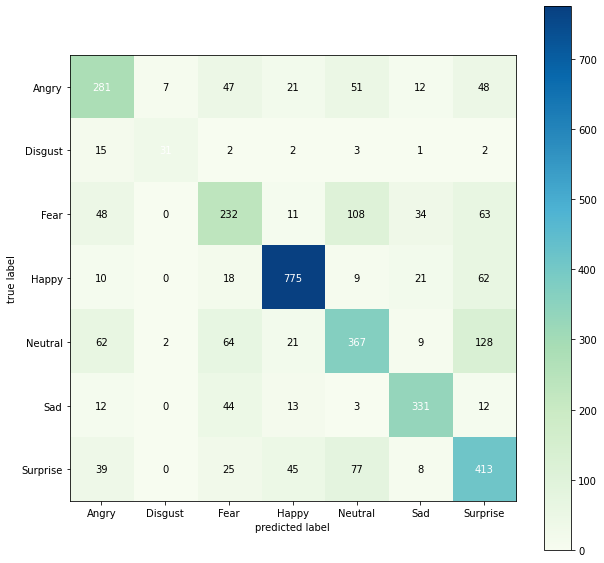

              precision    recall  f1-score   support

       Angry       0.60      0.60      0.60       467
     Disgust       0.78      0.55      0.65        56
        Fear       0.54      0.47      0.50       496
       Happy       0.87      0.87      0.87       895
         Sad       0.59      0.56      0.58       653
    Surprise       0.80      0.80      0.80       415
     Neutral       0.57      0.68      0.62       607

    accuracy                           0.68      3589
   macro avg       0.68      0.65      0.66      3589
weighted avg       0.68      0.68      0.68      3589



In [30]:
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,figsize=(10,10),cmap='GnBu')
ax.set_xticklabels([''] + list(np.unique(target_names)))
ax.set_yticklabels([''] + list(np.unique(target_names)))

plt.show()
print(clf)